# Generating Shakespearean Text Using a Character RNN

In a famous [2015 blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) titled “The Unreasonable Effectiveness of Recurrent Neural Networks,” Andrej Karpathy showed how to train an RNN to predict the next character in a sentence

This **Char-RNN** can then be used to generate novel text, one character at a time

## Creating the Training Dataset

First, let’s download all of Shakespeare’s work, using Keras’s handy get_file() function and downloading the data from Andrej Karpathy’ [Char-RNN project](https://github.com/karpathy/char-rnn):

In [17]:
import tensorflow as tf
import tensorflow.keras as keras

In [18]:
shakespeare_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
filepath = keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

Next, we must encode every character as an integer. One option is to create a custom preprocessing layer, as we did in Chapter 13

But in this case, it will be simpler to use Keras’ Tokenizer class. First we need to fit a **tokenizer** to the text: **it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters** (it does not start at 0, so we can use that value for masking, as we will see later in this chapter):

In [19]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

We set **char_level=True** to get **character-level encoding rather than the default word-level encoding**. Note that this **tokenizer converts the text to lowercase by default** (but you can set lower=False if you do not want that)

Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [20]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [21]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [22]:
max_id = len(tokenizer.word_index) # number of distinct characters
max_id

39

In [23]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1

Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [24]:
import numpy as np
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Before we continue, we need to split the dataset into a training set, a validation set, and a test set. We **can’t just shuffle all the characters in the text,** so how do you split a sequential dataset?

## How to Split a Sequential Dataset

For example, we can take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set

It would also be a good idea to **leave a gap between these sets** to **avoid** the risk of a **paragraph overlapping** over two sets

When dealing with time series, you would in **general split across time,:** for example, you might take the years **2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.** However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on

So, it is often safer to split across time—but this implicitly **assumes that the patterns the RNN can learn in the past** (in the training set) **will still exist in the future.** In other words, we assume that the time series is **stationary**

For many time series this assumption is reasonable **(e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day),** but f**or many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them)**

To **make sure** the time series is indeed sufficiently **stationary,** you can **plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough,** and you might be **better off training the model on a shorter time span.**

Now back to Shakespeare! Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [25]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## Chopping the Sequential Dataset into Multiple Windows

The training set now consists of a single sequence of **over a million characters,** so we **can’t just train the neural network directly** on it: **the RNN would be equivalent to a deep net with over a million layers,** and we would have a single (very long) instance to train it

Instead, we will use the dataset’s **window() method** to **convert** this long sequence of characters **into many smaller windows of text**

**Every instance** in the dataset will be a **fairly short substring of the whole text,** and the **RNN will be unrolled only over the length of these substrings.** This is called **truncated backpropagation through time**

Let's call the window() method to create a dataset of short text windows:

In [26]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

By **default,** the **window()** method **creates nonoverlapping windows,** but **to get the largest possible training set we use shift=1** so the **first window contains characters 0 to 100. the second contains characters 1 to 101,** and so on

To **ensure that all windows are exactly 101 characters** long (which will allow us to create batches without having to do any padding), we set **drop_remainder=True** (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character)

The **window() method creates a dataset that contains windows, each of which is also represented as a dataset.** It’s a **nested dataset,** analogous to a list of lists

This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we **cannot use a nested dataset directly for training,** as our model will **expect tensors as input,** not datasets

So, we must call the **flat_map() method:** it **converts a nested dataset into a flat dataset** (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. **If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}**

Moreover, the **flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening.** For example, if you pass the function **lambda ds: ds.batch(2) to flat_map(),** then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset **{[1, 2], [3, 4], [5, 6]}:** it’s a dataset of tensors of size 2 

With that in mind, we are ready to flatten our dataset:

In [27]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Notice that we call batch(window_length) on each window: since all windows have exactly that length, we will get a single tensor for each of them. **Now the dataset contains consecutive windows of 101 characters each**

Since **Gradient Descent** works best when the instances in the **training set are independent and identically distributed**, we need to shuffle these windows. Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [28]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Figure 16-1 summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32)

<p align='center'>
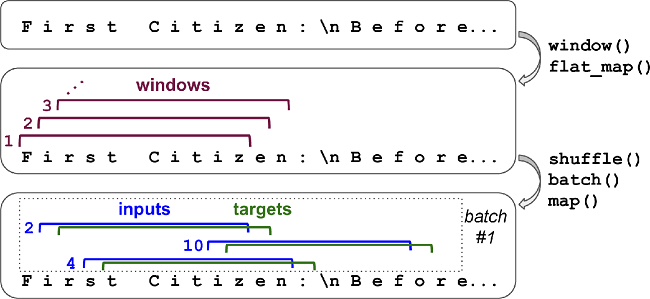
</p>
Figure 16-1. Preparing a dataset of shuffled windows

As discussed in Chapter 13, categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [29]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

Finally, we just need to add prefetching:

In [31]:
dataset = dataset.prefetch(1)

## Building and Training the Char-RNN Model